In [1]:
import time
start_time=time.time()

Abstract

Se presenta un ajuste polinomial (0-6 ord) a los datos observacionales para investigar movimientos a gran escala (detrended data) en direciones X y Y.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d
from scipy import interpolate

from SABReXX import sosf,acf,psk,ps,sosfnorm,sosfw,sosfw2,sosfs,sosfnorms,sfwh,pst
from CorrPoldef import CPV,CPH
from LRdefX import LR,ACLR
from Pltdef import pltdata

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

Input Data

In [3]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
lr=[6562.8,6548,6583,6717,6731]#AngstromsR
#lb=[4861.36,4958.9,5006.9]#AngstromsB


n=7

Astronomical Observations

In [4]:
inputf='595.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})


In [5]:
#LimitData
min0=75
max0=130
mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

Emission lines data

In [6]:
for i in range(1):
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-lr[Nx])/lr[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('dataII'+str(int(lr[Nx]))+'.csv')

# Muestra (i) H alfa

In [7]:
datap='dataII6562.csv'
dt=pd.read_csv(datap)
dt=dt.rename(columns={'Unnamed: 0':'No'})
dt=dt.drop('No',axis=1)
os.remove(datap)
dt.describe()

,X,Y,RV,I
count,369.00000,369.000000,369.000000,369.000000
mean,101.91600,10.555556,-1017.841296,1190.327263
std,15.88847,7.003320,15594.515616,1745.710725
min,75.09600,0.000000,-299766.779000,0.000000
25%,88.50600,5.000000,-213.594837,269.400000
50%,101.91600,11.000000,-204.641445,533.400000
75%,115.32600,15.000000,-196.555984,1159.000000
max,128.73600,22.000000,-177.781268,9957.000000


In [8]:
wd=dt.X.max()-dt.X.min()
hd=dt.Y.max()-dt.Y.min()
ar=wd/hd
sz=4

Statistical Data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


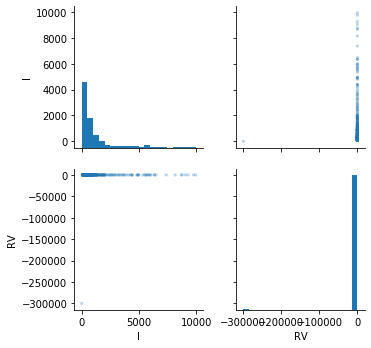

In [9]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


In [10]:
mx=(dt.RV<-100)&(dt.RV>-300)
dt=dt[mx]

In [11]:
dte=[109.96,5,-204,2420]
dte=pd.DataFrame(dte).T
dte.columns=['X','Y','RV','I']

In [12]:
dt=pd.concat([dt,dte], ignore_index=True)

In [13]:
dt.describe()

,X,Y,RV,I
count,369.000000,369.000000,369.000000,369.000000
mean,101.915995,10.555556,-206.018047,1196.885528
std,15.888467,7.003320,13.197008,1745.772479
min,75.096000,0.000000,-239.267319,54.730000
25%,88.506000,5.000000,-213.503476,270.800000
50%,101.916000,11.000000,-204.595764,537.500000
75%,115.326000,15.000000,-196.555984,1165.000000
max,128.736000,22.000000,-177.781268,9957.000000


In [14]:
#mr=dt['RV']>dt['RV'].mean()+0.005*dt['RV'].std()
mf=dt['I']>dt['I'].mean()+.05*dt['I'].std()
dt=dt[mf]

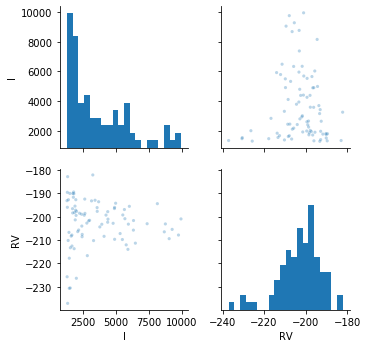

In [15]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


Emission Map

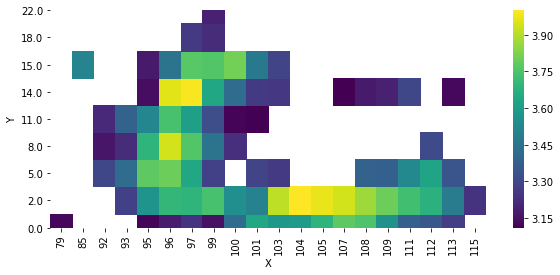

In [16]:
datal=dt.copy()
datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
#datal.Y=datal.Y.astype(int)

dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_f, cmap="viridis",xticklabels='auto')
plt.gca().invert_yaxis()
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="16"

Radial Velocity

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


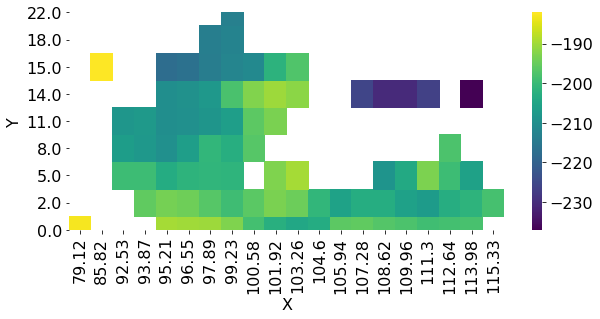

In [17]:
datal=dt.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Weighted property

In [18]:
W=np.log(abs((dt.RV*dt.I)/dt.I.sum()))
W.head()

22     0.070521
63     0.143499
64     0.242427
101    0.221328
102    0.655155
dtype: float64

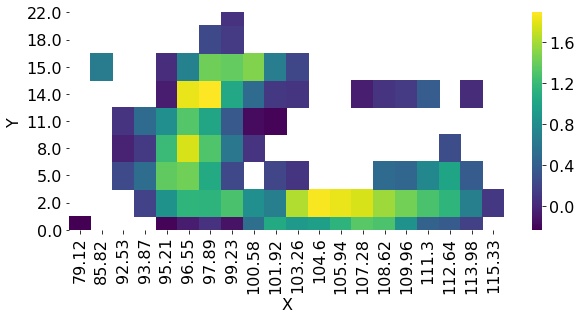

In [19]:
dtW=[dt.X,dt.Y,W]
dtW=pd.DataFrame(dtW).T
dtW.columns=['X','Y','W']

dtH_W=(dtW.round(2)).pivot(index='Y', columns='X', values='W')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dtH_W, cmap="viridis")
plt.gca().invert_yaxis()


Horizontal Polynomial Correction

 
-202.8
 
-0.308 x - 171.4
         2
0.01531 x - 3.42 x - 14.02
           3          2
-0.002566 x + 0.7713 x - 77.18 x + 2369
           4           3         2
0.0001337 x - 0.05505 x + 8.462 x - 575.3 x + 1.44e+04
           5           4         3         2
5.211e-05 x - 0.02549 x + 4.966 x - 481.7 x + 2.325e+04 x - 4.469e+05
            6           5          4         3        2
-1.931e-06 x + 0.00119 x - 0.3039 x + 41.19 x - 3124 x + 1.257e+05 x - 2.097e+06


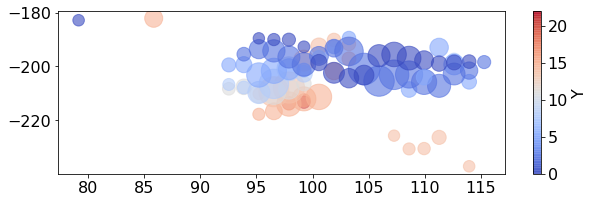

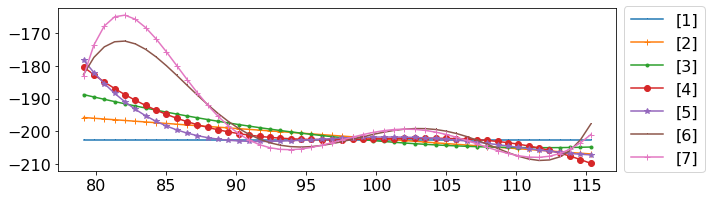

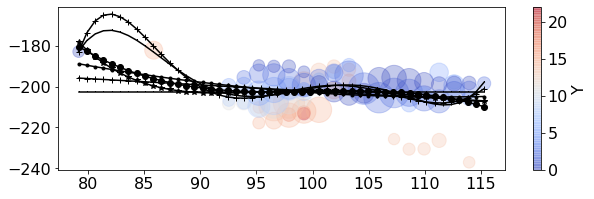

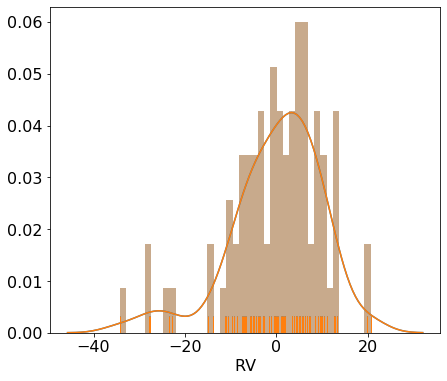

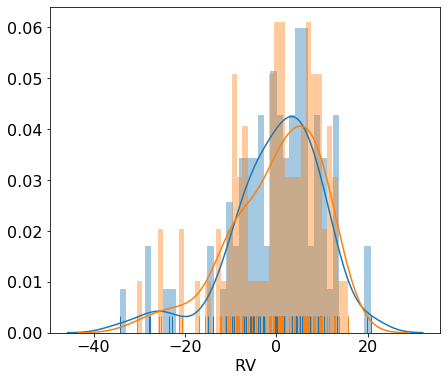

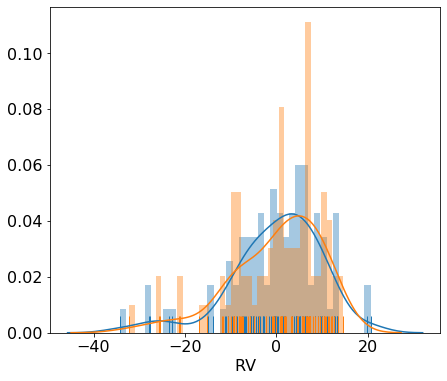

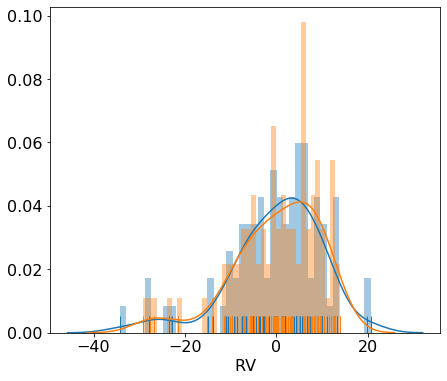

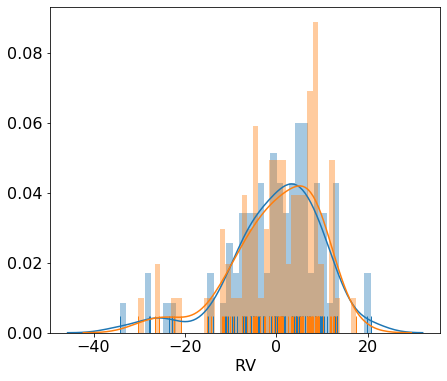

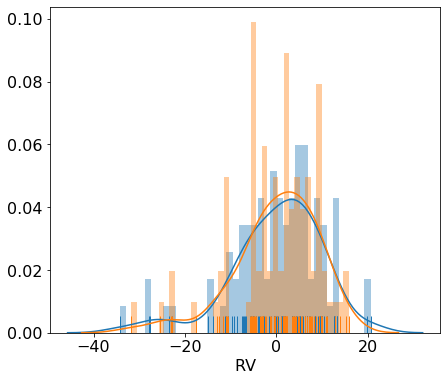

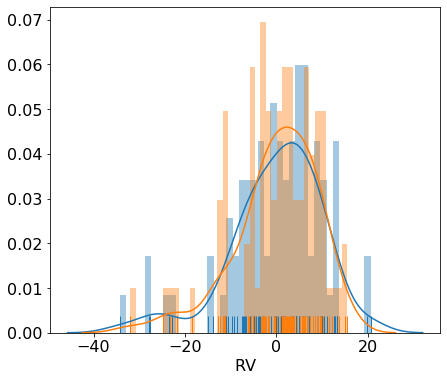

In [20]:
argo1=CPH(dt,n)

Vertical Polynomial Correction

 
-202.8
 
-0.8905 x - 196.5
          2
0.003732 x - 0.9515 x - 196.4
          3           2
0.001408 x - 0.03608 x - 0.6685 x - 196.7
           4           3          2
0.0003709 x - 0.01368 x + 0.1498 x - 1.36 x - 196.4
            5            4          3         2
-0.0001051 x + 0.005672 x - 0.1052 x + 0.777 x - 2.77 x - 196
           6             5          4          3         2
9.416e-06 x - 0.0006829 x + 0.0188 x - 0.2403 x + 1.386 x - 3.689 x - 196


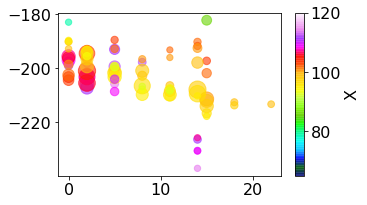

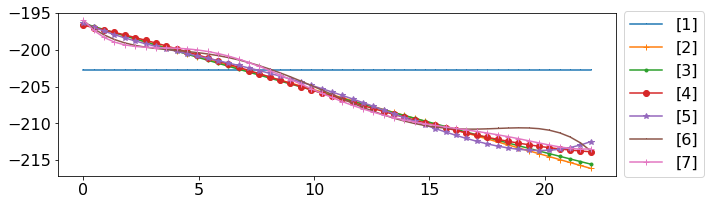

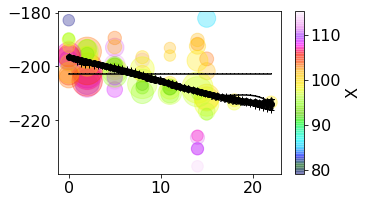

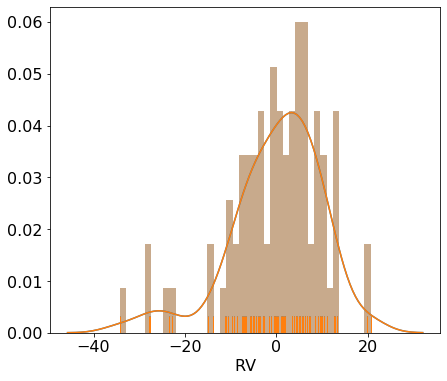

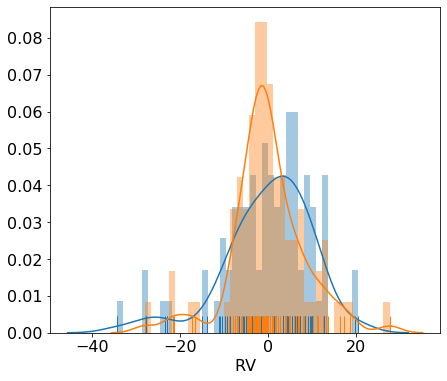

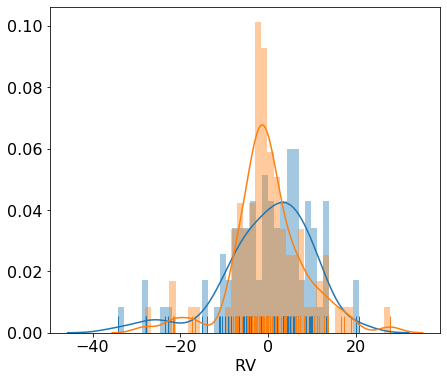

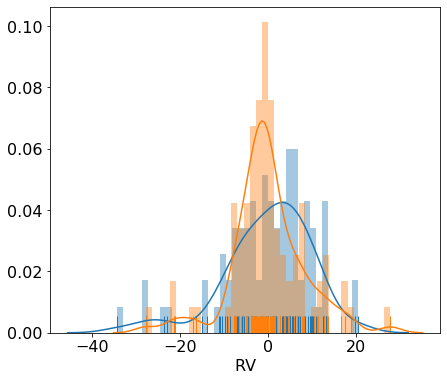

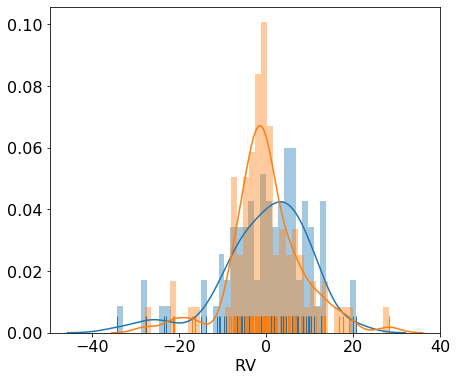

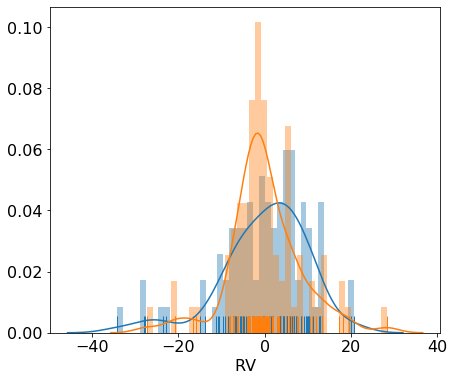

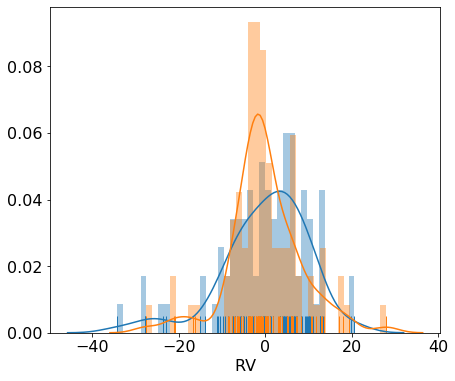

In [21]:
argo2=CPV(dt,n)

Structure Function

In [22]:
SF1=dict()

for i in range(n):
    SF1[i]=sosf(argo1[i])
    
SF2=dict()

for i in range(n):
    SF2[i]=sosf(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:253: RuntimeWarning: invalid value encountered in log
  e=np.log(a/b)


In [23]:
xi=1
xf=15

SF1Data=dict()
SF1Pr=dict()

for i in range(n):
    SF1Data[i],SF1Pr[i]=LR(SF1[i]['Lag'],SF1[i]['Nmqvd'],SF1[i]['ErrY'],xi,xf,n)
    
SF2Data=dict()
SF2Pr=dict()


for i in range(n):
    SF2Data,SF2Pr[i]=LR(SF2[i]['Lag'],SF2[i]['Nmqvd'],SF2[i]['ErrY'],xi,xf,n)

In [24]:
SF1Data,SF2Data

({0:               R        eps     alpha  lags
  Value  0.936877  14.298225  1.114469   2.0
  Err    0.002213   0.742996  0.009590  15.0,
  1:               R        eps     alpha  lags
  Value  0.927561  15.983515  1.057767   2.0
  Err    0.002537   0.837843  0.010257  15.0,
  2:               R        eps     alpha  lags
  Value  0.925402  16.057786  1.065154   2.0
  Err    0.002529   0.838598  0.010138  15.0,
  3:               R        eps     alpha  lags
  Value  0.935414  15.282278  1.066609   2.0
  Err    0.002077   0.782489  0.009470  15.0,
  4:               R        eps     alpha  lags
  Value  0.934703  15.087301  1.059420   2.0
  Err    0.002224   0.778249  0.009607  15.0,
  5:               R       eps     alpha  lags
  Value  0.932062  15.98738  0.984006   2.0
  Err    0.001682   0.74579  0.007360  15.0,
  6:               R        eps     alpha  lags
  Value  0.929185  15.539553  0.986697   2.0
  Err    0.001825   0.738292  0.007728  15.0},
               R        eps  

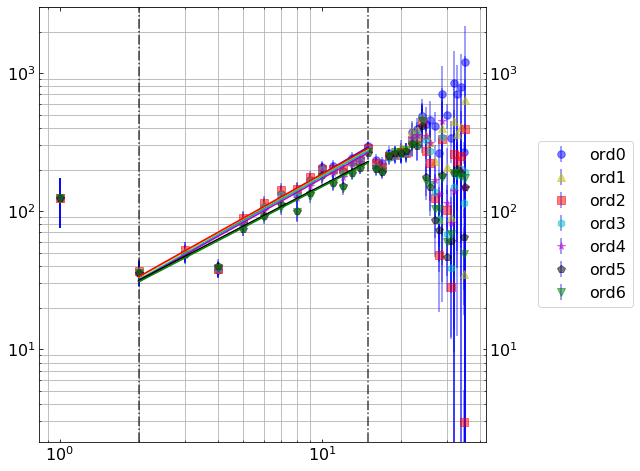

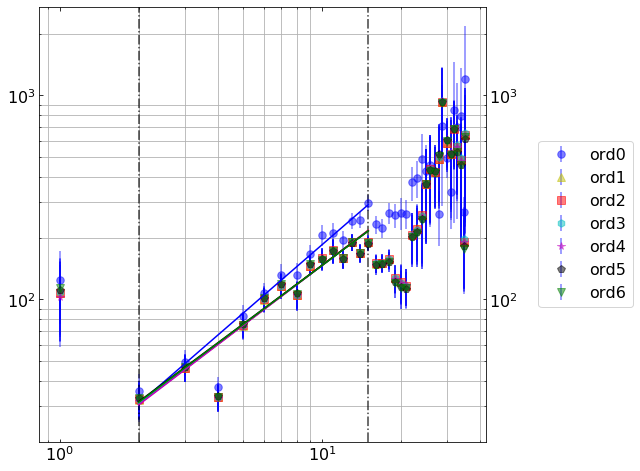

In [25]:
pltdata(SF1,SF1Pr,xi,xf,n)
pltdata(SF2,SF2Pr,xi,xf,n)

Structure Function Norm

In [26]:
SFn1=dict()

for i in range(n):
    SFn1[i]=sosfnorm(argo1[i])
    
SFn2=dict()

for i in range(n):
    SFn2[i]=sosfnorm(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:702: RuntimeWarning: invalid value encountered in log
  e=np.log(a/b)


In [27]:
xi=1
xf=15

SFN1Data=dict()
SFN1Pr=dict()

for i in range(n):
    SFN1Data[i],SFN1Pr[i]=LR(SFn1[i]['Lag'],SFn1[i]['Nmqvd'],SFn1[i]['ErrY'],xi,xf,n)
    
SFN2Data=dict()
SFN2Pr=dict()

for i in range(n):
    SFN2Data[i],SFN2Pr[i]=LR(SFn2[i]['Lag'],SFn2[i]['Nmqvd'],SFn2[i]['ErrY'],xi,xf,n)

In [28]:
SFN1Data,SFN2Data

({0:               R       eps     alpha  lags
  Value  0.936760  0.142143  1.114254   2.0
  Err    0.002167  0.007397  0.009612  15.0,
  1:               R       eps     alpha  lags
  Value  0.927856  0.166499  1.057874   2.0
  Err    0.002507  0.008702  0.010190  15.0,
  2:               R       eps     alpha  lags
  Value  0.925400  0.169325  1.065294   2.0
  Err    0.002586  0.008850  0.010164  15.0,
  3:               R       eps     alpha  lags
  Value  0.935380  0.167115  1.066422   2.0
  Err    0.002066  0.008583  0.009540  15.0,
  4:               R       eps     alpha  lags
  Value  0.934501  0.166231  1.059020   2.0
  Err    0.002225  0.008590  0.009647  15.0,
  5:               R       eps     alpha  lags
  Value  0.931932  0.192528  0.984162   2.0
  Err    0.001702  0.008954  0.007294  15.0,
  6:               R       eps     alpha  lags
  Value  0.929137  0.188785  0.986624   2.0
  Err    0.001798  0.008964  0.007724  15.0},
 {0:               R       eps     alpha  lags


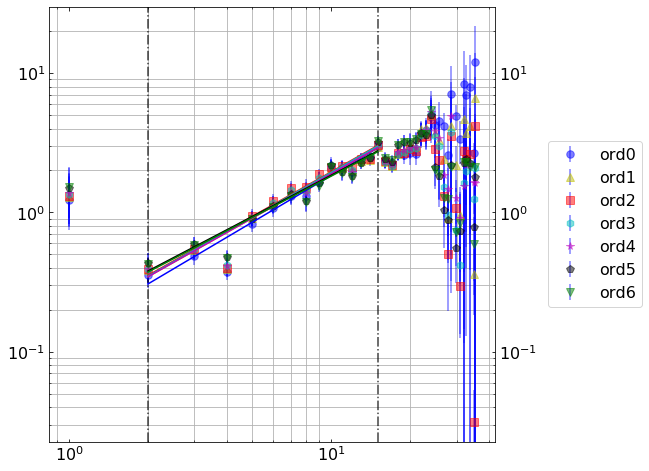

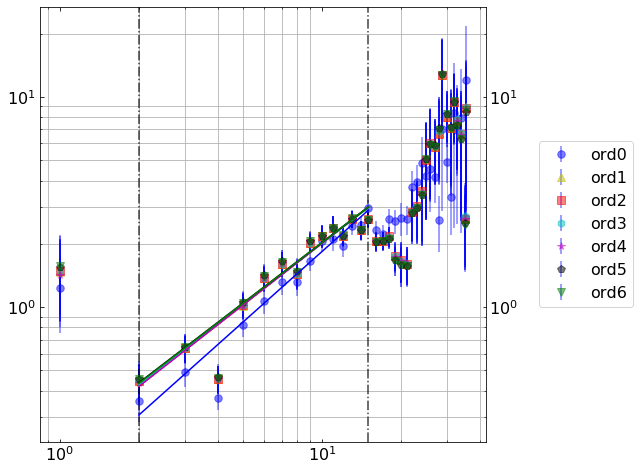

In [29]:
pltdata(SFn1,SFN1Pr,xi,xf,n)
pltdata(SFn2,SFN2Pr,xi,xf,n)

Weighted Structure Function

In [30]:
SFw1=dict()

for i in range(n):
    SFw1[i]=sosfw(argo1[i])

SFw2=dict()

for i in range(n):
    SFw2[i]=sosfw(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1171: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1180: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1178: RuntimeWarning: invalid value encountered in log
  e=np.log(a/b)


In [31]:
xi=1
xf=15

SFW1Data=dict()
SFW1Pr=dict()


for i in range(n):
    SFW1Data[i],SFW1Pr[i]=LR(SFw1[i]['Lag'],SFw1[i]['Nmqvd'],SFw1[i]['ErrY'],xi,xf,n)
    
SFW2Data=dict()
SFW2Pr=dict()


for i in range(n):
    SFW2Data[i],SFW2Pr[i]=LR(SFw2[i]['Lag'],SFw2[i]['Nmqvd'],SFw2[i]['ErrY'],xi,xf,n)

In [32]:
SFW1Data,SFW2Data

({0:               R        eps     alpha  lags
  Value  0.760465  10.685798  0.680397   2.0
  Err    0.009126   0.545123  0.010486  15.0,
  1:               R        eps     alpha  lags
  Value  0.777295  12.001065  0.652706   2.0
  Err    0.009094   0.618811  0.010755  15.0,
  2:               R        eps     alpha  lags
  Value  0.784973  12.410357  0.648242   2.0
  Err    0.009141   0.646895  0.011106  15.0,
  3:               R        eps     alpha  lags
  Value  0.761285  12.734506  0.624451   2.0
  Err    0.009604   0.655643  0.011203  15.0,
  4:               R        eps     alpha  lags
  Value  0.745397  12.219504  0.641320   2.0
  Err    0.009585   0.619635  0.010497  15.0,
  5:               R        eps     alpha  lags
  Value  0.727056  15.232356  0.543518   2.0
  Err    0.007535   0.785889  0.010518  15.0,
  6:               R        eps     alpha  lags
  Value  0.696258  14.497684  0.561089   2.0
  Err    0.008972   0.734102  0.010159  15.0},
 {0:               R      

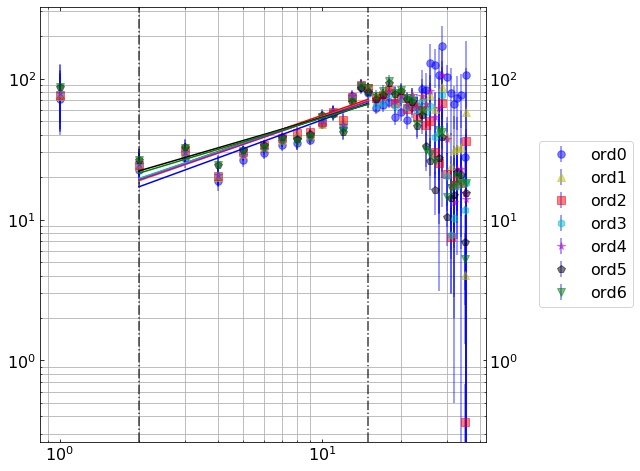

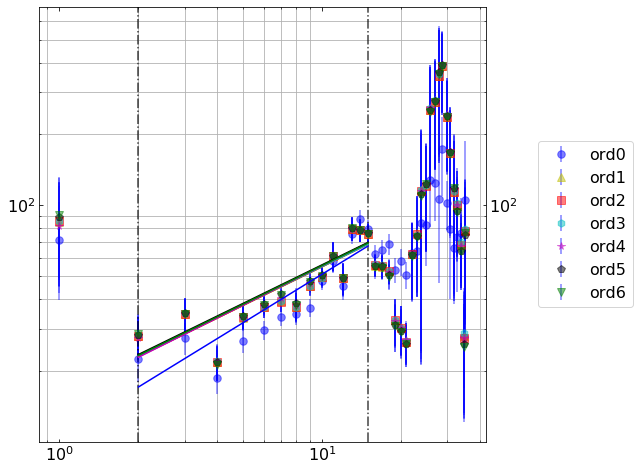

In [33]:
pltdata(SFw1,SFW1Pr,xi,xf,n)
pltdata(SFw2,SFW2Pr,xi,xf,n)

Weighted Property

In [34]:
SFwII1=dict()

for i in range(n):
    SFwII1[i]=sosfw2(argo1[i])
    
SFwII2=dict()

for i in range(n):
    SFwII2[i]=sosfw2(argo1[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1651: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1658: RuntimeWarning: invalid value encountered in log
  e=np.log(a/b)


In [35]:
xi=1
xf=25

SFWII1Data=dict()
SFWII1Pr=dict()

for i in range(n):
    SFWII1Data[i],SFWII1Pr[i]=LR(SFwII1[i]['Lag'],SFwII1[i]['Nmqvd'],SFwII1[i]['ErrY'],xi,xf,n)
    
SFWII2Data=dict()
SFWII2Pr=dict()

for i in range(n):
    SFWII2Data[i],SFWII2Pr[i]=LR(SFwII2[i]['Lag'],SFwII2[i]['Nmqvd'],SFwII2[i]['ErrY'],xi,xf,n)

In [36]:
SFWII1Data,SFWII2Data

({0:               R       eps     alpha    lags
  Value  0.788854  0.763982  0.406001   2.000
  Err    0.007669  0.016299  0.005253  24.894,
  1:               R       eps     alpha    lags
  Value  0.847477  0.702686  0.443655   2.000
  Err    0.003420  0.019730  0.001958  24.894,
  2:               R       eps     alpha    lags
  Value  0.781868  0.791282  0.387084   2.000
  Err    0.011877  0.021780  0.002147  24.894,
  3:               R       eps     alpha    lags
  Value  0.824650  0.784200  0.403119   2.000
  Err    0.002051  0.022927  0.000905  24.894,
  4:               R       eps     alpha    lags
  Value  0.823864  0.715058  0.439948   2.000
  Err    0.002243  0.020050  0.001843  24.894,
  5:               R       eps     alpha    lags
  Value  0.573370  0.867157  0.349258   2.000
  Err    0.013219  0.024387  0.002003  24.894,
  6:               R       eps     alpha    lags
  Value  0.558673  0.825569  0.366720   2.000
  Err    0.015484  0.021517  0.003287  24.894},
 {0: 

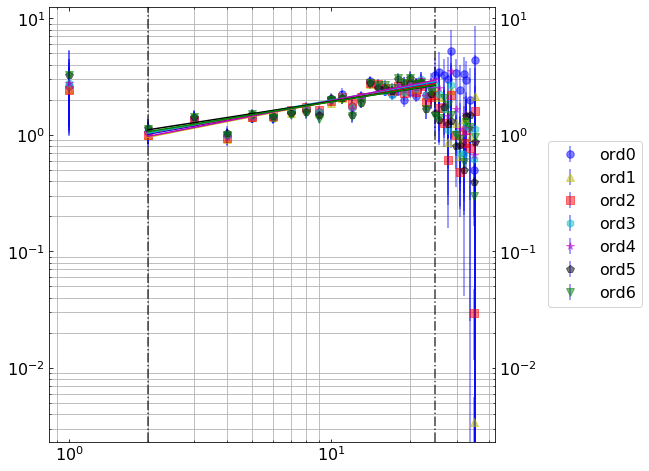

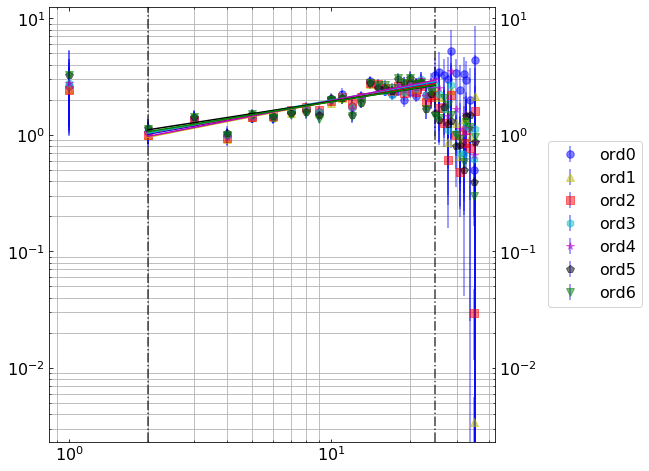

In [37]:
pltdata(SFwII1,SFWII1Pr,xi,xf,n)
pltdata(SFwII2,SFWII2Pr,xi,xf,n)

Structure Function Dr. Will

In [38]:
SFwh1=dict()

for i in range(n):
    SFwh1[i]=sfwh(argo1[i])
    
SFwh2=dict()

for i in range(n):
    SFwh2[i]=sfwh(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [39]:
xi=1
xf=2

SFwh1Data=dict()
SFwh1Pr=dict()

for i in range(n):
    SFwh1Data[i],SFwh1Pr[i]=LR(SFwh1[i]['Lag'],SFwh1[i]['Nmqvd'],SFwh1[i]['ErrY'],xi,xf,n)
    
SFwh2Data=dict()
SFwh2Pr=dict()

for i in range(n):
    SFwh2Data[i],SFwh2Pr[i]=LR(SFwh2[i]['Lag'],SFwh2[i]['Nmqvd'],SFwh2[i]['ErrY'],xi,xf,n)

/home/zalenovo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-define

In [40]:
SFwh1Data,SFwh2Data

({0:         R         eps  alpha    lags
  Value NaN  361.368667    0.0  13.175
  Err   NaN    5.271846    0.0  13.175, 1:         R        eps  alpha    lags
  Value NaN  306.57800    0.0  13.175
  Err   NaN    4.59361    0.0  13.175, 2:         R         eps  alpha    lags
  Value NaN  319.076667    0.0  13.175
  Err   NaN    4.924019    0.0  13.175, 3:         R         eps  alpha    lags
  Value NaN  319.674667    0.0  13.175
  Err   NaN    4.557412    0.0  13.175, 4:         R         eps  alpha    lags
  Value NaN  314.324667    0.0  13.175
  Err   NaN    4.487193    0.0  13.175, 5:         R         eps  alpha    lags
  Value NaN  300.544667    0.0  13.175
  Err   NaN    4.255308    0.0  13.175, 6:         R         eps  alpha    lags
  Value NaN  303.097667    0.0  13.175
  Err   NaN    4.251226    0.0  13.175},
 {0:         R         eps  alpha    lags
  Value NaN  361.368667    0.0  13.175
  Err   NaN    5.271846    0.0  13.175, 1:         R         eps  alpha    lags
  Valu

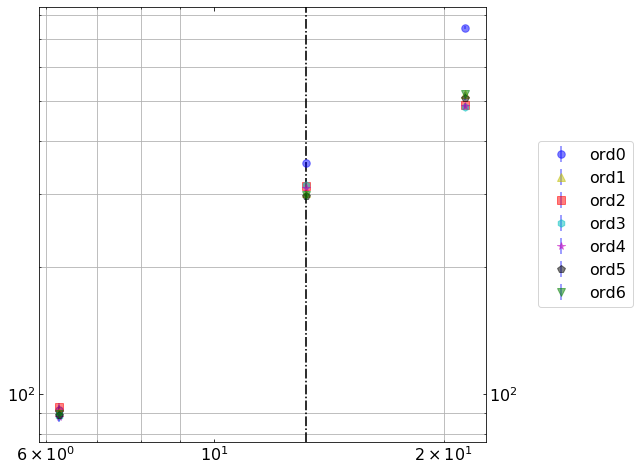

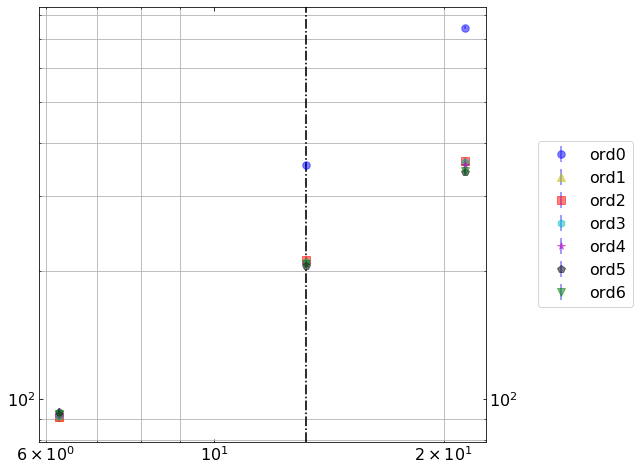

In [41]:
pltdata(SFwh1,SFwh1Pr,xi,xf,n)
pltdata(SFwh2,SFwh2Pr,xi,xf,n)

Autocorrelation Function

In [42]:
AF1=dict()

for i in range(n):
    AF1[i]=acf(argo1[i])
    
AF2=dict()

for i in range(n):
    AF2[i]=acf(argo2[i])

In [43]:
AF1Data=dict()
AF1Inter=dict()


for i in range(n):

    AF1Data[i],AF1Inter[i]=ACLR(AF1[i])
    
AF2Data=dict()
AF2Inter=dict()


for i in range(n):

    AF2Data[i],AF2Inter[i]=ACLR(AF2[i])
    

AF1Data,AF2Data 

({0: array([ 9.41157013, 18.08039678, 18.71998533]),
  1: array([ 9.86518968, 28.69371326]),
  2: array([ 9.68965781, 28.91415982]),
  3: array([ 9.54364322, 30.33219579]),
  4: array([ 9.96491027, 29.99389398]),
  5: array([10.45297871, 29.5207281 ]),
  6: array([11.44331966, 29.79390729, 31.70330397])},
 {0: array([ 9.41157013, 18.08039678, 18.71998533]),
  1: array([ 7.16488107, 15.28956433, 21.58978907]),
  2: array([ 7.17148285, 15.29151675, 21.58005385]),
  3: array([ 7.17884343, 15.32458711, 21.59094506]),
  4: array([ 7.18615086, 15.25247911, 21.59122247]),
  5: array([ 7.08609087, 15.30482391, 21.75862236]),
  6: array([ 7.12198369, 15.37423897, 21.74098404])})

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


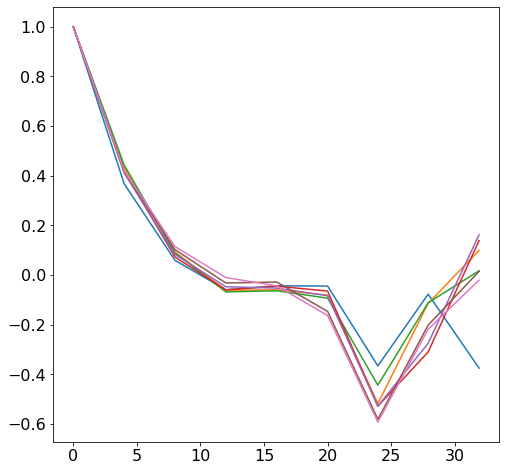

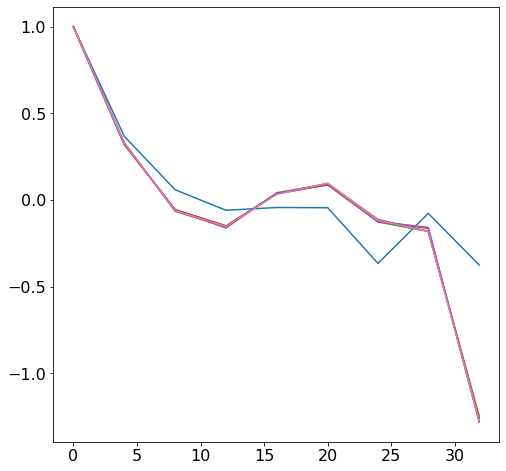

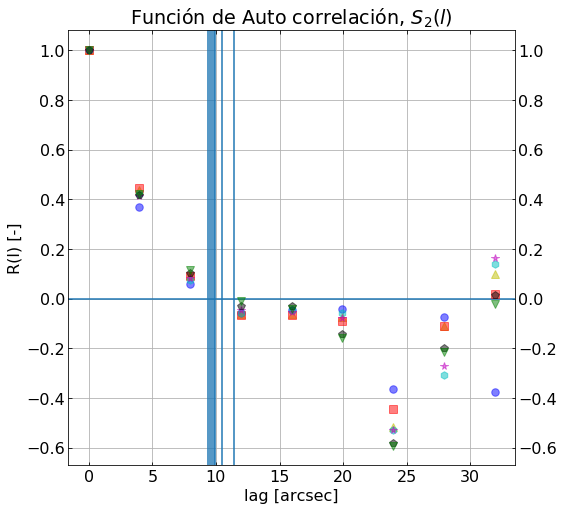

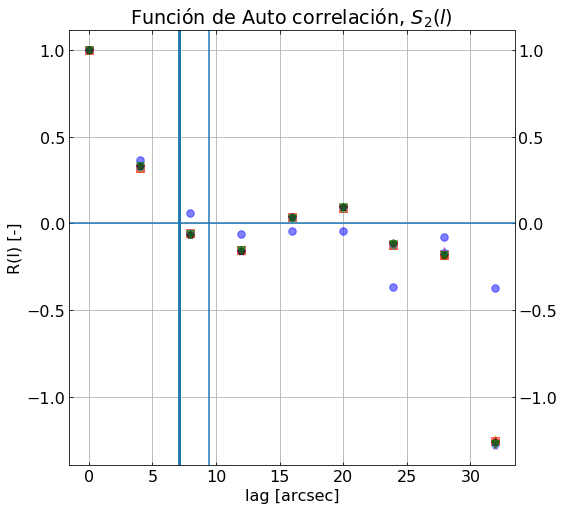

In [44]:
fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    plt.plot(AF1[i]['Lag'],AF1[i]['Nmqvd'])

fig, ax=plt.subplots(figsize=(8,8))
    
for i in range(n):
    plt.plot(AF2[i]['Lag'],AF2[i]['Nmqvd'])
    
marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF1Inter[i][0],AF1Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF1Data[y][i])



marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF2Inter[i][0],AF2Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF2Data[y][i])

1DPSD

In [45]:
#PS1=dict()

#for i in range(n):
#    PS1[i]=ps(argo1[i])
    
#PS2=dict()

#for i in range(n):
#    PS2[i]=ps(argo2[i])

In [46]:
#xi=1
#xf=20

#PS1Data=dict()
#mx=len(PS1[i]['k'])
#PS1Pr=dict()

#for i in range(n):
#    PS1Data[i],PS1Pr[i]=LR(PS1[i]['k'][1:mx],PS1[i]['Pk'][1:mx],PS1[i]['Err'][1:mx],xi,xf,n)
    
#PS2Data=dict()
#PS2Pr=dict()

#for i in range(n):
#    PS2Data[i],PS2Pr[i]=LR(PS2[i]['k'][1:mx],PS2[i]['Pk'][1:mx],PS2[i]['Err'][1:mx],xi,xf,n)

In [47]:
#PS1Data,PS2Data

In [48]:
#pltdata(PS1,PS1Pr,xi+1,xf,n)
#pltdata(PS2,PS2Pr,xi+1,xf,n)

In [49]:
#PS1k=dict()

#for i in range(n):
#    PS1k[i]=psk(argo1[i])
    
#PS2k=dict()

#for i in range(n):
#    PS2k[i]=psk(argo2[i])

In [50]:
#xi=1
#xf=19

#PS1kData=dict()
#mx=len(PS1k[0]['k'])
#PS1kPr=dict()


#for i in range(n):
#    PS1kData[i],PS1kPr[i]=LR(PS1k[i]['k'][1:mx],PS1k[i]['Pk'][1:mx],PS1k[i]['Err'][1:mx],xi,xf,n)
    
#PS2kData=dict()
#PS2kPr=dict()

#for i in range(n):
#    PS2kData[i],PS2kPr[i]=LR(PS2k[i]['k'][1:mx],PS2k[i]['Pk'][1:mx],PS2k[i]['Err'][1:mx],xi,xf,n)

In [51]:
#PS1kData,PS2kData

In [52]:
#pltdata(PS1k,PS1kPr,xi,xf+1,n)
#pltdata(PS2k,PS1kPr,xi,xf+1,n)

1DPSD Turbustat

In [53]:
PST1a=dict()
PST1b=dict()


for i in range(n):
    PST1a[i],PST1b[i]=pst(argo1[i])
    
PST2a=dict()
PST2b=dict()

for i in range(n):
    PST2a[i],PST1b[i]=pst(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/b

In [54]:
for i in range(n):
    print(PST1a[i].slope2D,PST1a[i].slope2D_err)
    


-1.114704214565479 0.25702026132003475
-1.1823058069996237 0.21598574166326012
-1.1489236607472166 0.23738576795351263
-1.0245057577058236 0.24127230481803597
-0.9881207984217005 0.2190313899069744
-0.7819544693246293 0.23053765446887764
-0.7858993622252171 0.24634447471555765


In [55]:
for i in range(n):
    print(PST2a[i].slope2D,PST2a[i].slope2D_err)

-1.114704214565479 0.27609224358123724
-0.7770066852915112 0.2540092614032289
-0.7207203447012549 0.25666300066514014
-0.7524456003639869 0.261981823057961
-0.8223090717381049 0.26368943179403487
-0.770015309004196 0.27273205045574533
-0.7476097118576924 0.2236823249349989


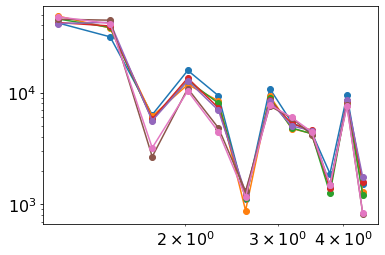

In [56]:
for i in range(n):
    plt.loglog(PST1a[i].wavenumbers,PST1a[i].ps1D,'o-', label=str(i))
    #plt.legend()

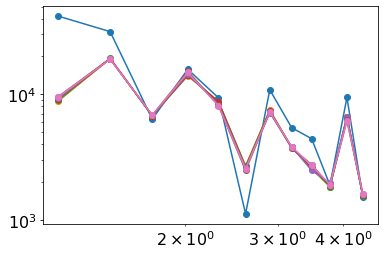

In [57]:
for i in range(n):
    plt.loglog(PST2a[i].wavenumbers,PST2a[i].ps1D,'o-', label=str(i))
    #plt.legend()

In [58]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 102.56247568130493 seconds ---


In [59]:
#SF1

In [60]:
#SF1.to_csv('SF1.csv')